In [1]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from sklearn.neighbors import KDTree
import shapely
from core.cluster_validation import generate_detailed_clusters
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import cluster_data

CPU times: user 11.4 s, sys: 367 ms, total: 11.7 s
Wall time: 9.37 s


In [2]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
val_path = '../data/prague_validation/morphotopes.pq'

In [3]:
region_id = 'freiburg'
buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
chars_dir = '../data/freiburg/chars/'
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'
val_path = '../data/fbg_cluster_validation.pq'

In [4]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)
morphotopes = gpd.read_parquet(val_path)

In [5]:
def boundary_distance_metric(tessellation, clusters, morphotopes, segmentation_distance=10):
    cluster_boundaries = tessellation.dissolve(clusters)
    boundaries = cluster_boundaries.buffer(1e-6).boundary
    coords = morphotopes.segmentize(segmentation_distance).get_coordinates(index_parts=True)
    morphotopes_points = coords.set_geometry(gpd.points_from_xy(*coords.values.T), crs=morphotopes.crs)
    _, dist = boundaries.sindex.nearest(morphotopes_points.geometry, return_distance=True, max_distance=500, return_all=False)
    morphotopes_points["distance"] = dist
    return morphotopes_points.groupby(level=0)["distance"].describe().set_geometry(morphotopes.geometry)

In [6]:


tess_groups = generate_detailed_clusters(tessellation,
                                         include_random_sample=False, path=val_path)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]


tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train[X_train.index >=0])), index=X_train[X_train.index >=0].index)
    .loc[tess_groups.index]
    .values
)

In [7]:
spatial_lags = [1, 2, 3, 4, 5]
kernels = ['gaussian', 'inverse', 'weights']
lag_types = ['_median', '_iqr', '_']
cluster_sizes = [50, 75, 100, 150, 250]
chars_to_drop = [
    [],
    ['stcSAl', 'stcOri'],
    [
       'stcSAl',
       'ltkOri',
         'stbOri',
         'stcOri',
         'stbCeA'
    ]
          
]
clips = [None, (-5,5), (-10, 10)]


linkage = 'ward'
metric = 'euclidean'
centroids = shapely.get_coordinates(tessellation.representative_point())

In [8]:
%%capture cap

results = []

for spatial_lag in spatial_lags:
    
    for kernel in kernels:

        lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)

        for lag_type in lag_types:
            
            clustering_data = X_train.join(lag[[c for c in lag.columns if lag_type in c]], how='inner')
            
            for min_cluster_size in cluster_sizes:
                
                for to_drop in chars_to_drop:

                    for clip in clips:
                    
                        try:
                            region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)
                            ars = adjusted_rand_score(tess_groups.values, region_cluster_labels.iloc[tess_groups_ilocs].values)
                            bdm_df = boundary_distance_metric(tessellation[tessellation.index > -1], region_cluster_labels, morphotopes)
                            results.append([spatial_lag, kernel, lag_type, clip, min_cluster_size, to_drop, ars, bdm_df['mean'].mean(), bdm_df['std'].mean()])
                        except Exception as e:
                            print(f"spatial lag: {spatial_lag}, kernel: {kernel}, lag_type: {lag_type}, min_cluster_size: {min_cluster_size}, to_drop: {to_drop}")
                            print(e)

In [9]:
results = pd.DataFrame(results, columns= ['spatial_lag', 'kernel', 'lag_type', 'clip', 'min_cluster_size', 'dropped_cols', 'ars', 'bdm_df_mean', 'bdm_df_std'])


In [10]:
results.to_parquet(f'../data/cluster_log_{region_id}.pq')

In [ ]:
# results = pd.read_parquet(f'../data/cluster_log_{region_id}.pq')

In [ ]:
# results[results.min_cluster_size == 100].sort_values('ars', ascending=False).iloc[:30]

----

In [8]:
from core.generate_clusters import preprocess_clustering_data, get_clusters, post_process_clusters, get_tree
# # label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels

In [9]:
min_cluster_size = 100
spatial_lag = 3
kernel='gaussian'

to_drop = []
# to_drop = ['stcSAl', 'stcOri']
# to_drop = [
#        'stcSAl',
#        'ltkOri',
#          'stbOri',
#          'stcOri',
#          'stbCeA'
# ]

lag_type = '_median'

clip = None
linkage='ward'
metric='euclidean'

In [10]:
%%time
lag = spatially_weighted_partial_lag(X_train, graph, centroids, kernel=kernel, k=spatial_lag, n_splits=10)
lag = lag[[c for c in lag.columns if lag_type in c]]
clustering_data = X_train.join(lag, how='inner')

CPU times: user 27.1 s, sys: 1.95 s, total: 29.1 s
Wall time: 8.85 s


In [11]:
# clustering_data = X_train.copy()
# clip = (-3,3)
# to_drop = [
#        'stcSAl',
#        'ltkOri',
#          'stbOri',
#          'stcOri',
#          'stbCeA'
# ]

In [12]:
clustering_data.shape

(36183, 126)

In [13]:
%%time
region_cluster_labels = cluster_data(clustering_data, graph, to_drop, clip, min_cluster_size, linkage, metric)

CPU times: user 3.46 s, sys: 135 ms, total: 3.59 s
Wall time: 3.54 s


In [14]:
from sklearn.metrics import silhouette_score

In [15]:
silhouette_score(clustering_data.iloc[tess_groups_ilocs].fillna(0), region_cluster_labels[tess_groups_ilocs])

-0.5598941954662207

In [16]:
# gpd.read_parquet('../data/morphotopes_freiburg_100_3_gaussian.pq').explore()

In [17]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [18]:
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels
labels.value_counts()

component labels
3     34505
4       771
21      614
23       79
9        18
7        17
24       16
6         8
22        7
19        5
8         4
25        3
26        2
5         2
28        2
18        1
27        1
20        1
0         1
17        1
16        1
15        1
1         1
13        1
12        1
11        1
10        1
2         1
14        1
Name: count, dtype: int64

In [19]:
label = 3
labels.groupby(labels).get_group(label).shape

(34505,)

In [20]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [21]:
# buildings = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')

In [22]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values].reset_index()
plotting['label'] = region_cluster_labels[region_cluster_labels.str.startswith(str(label))].values
# plotting['label'] = plotting['label']
plotting['label'] = plotting['label'].str.split('_').str[1].astype(int)
plotting.shape

(34505, 4)

In [23]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [24]:
plotting['label'].nunique()

194

In [25]:
# buildings = gpd.read_parquet(buildings_dir + 'buildings_freiburg.parquet')
# plotting = buildings

In [26]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 585 ms, sys: 41.3 ms, total: 626 ms
Wall time: 625 ms


In [27]:
from sidecar import Sidecar
sc = Sidecar(title='Morphotopes')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [29]:
layer.get_fill_color = get_color(plotting['label'].values)

In [294]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
morph_clrs_geometry = clrs_geometry.set_geometry('geometry').reset_index()

CPU times: user 2.85 s, sys: 1.09 ms, total: 2.85 s
Wall time: 2.85 s


In [295]:
morph_clrs_geometry.to_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [296]:
gpd.read_parquet(f'../data/morphotopes_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq').explore()

----

In [199]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [226]:
# component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

component_data = X_train.loc[region_cluster_labels.index]

In [227]:
# component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

In [228]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 
#                                                              'median', 
#                                                              percentile(90)])

In [229]:
%%time
component_data = component_data.groupby(region_cluster_labels.values).agg([percentile(10), 
                                                             'median', 
                                                             percentile(90)])

CPU times: user 1.44 s, sys: 51 μs, total: 1.44 s
Wall time: 1.43 s


In [230]:
component_data

sdbAre                                  sdbPer             \
       percentile_10      median percentile_90 percentile_10     median   
0_1.0     158.469588  158.469588    158.469588     51.195015  51.195015   
10_1.0     24.995869   24.995869     24.995869     20.325831  20.325831   
11_1.0      6.378458    6.378458      6.378458     10.146418  10.146418   
12_1.0    117.428260  117.428260    117.428260     44.472631  44.472631   
13_1.0    134.018525  134.018525    134.018525     56.066456  56.066456   
...              ...         ...           ...           ...        ...   
5_1.0      71.601454  127.778758    183.956061     36.044147  51.116402   
6_1.0      16.593783   22.347574    104.627653     17.377131  19.745407   
7_1.0      18.271826  166.434128    565.836413     17.577434  52.009857   
8_1.0      55.468548   66.930641    155.223430     31.041228  40.410358   
9_1.0      14.158693   92.076144   2532.373037     15.417828  40.555035   

                            sdbCoA                             ssbCCo  ...  \
       percentile_90 percentile_10 median percentile_90 percentile_10  ...   
0_1.0      51.195015           0.0    0.0           0.0      0.595764  ...   
10_1.0     20.325831           0.0    0.0           0.0      0.595020  ...   
11_1.0     10.146418           0.0    0.0           0.0      0.624573  ...   
12_1.0     44.472631           0.0    0.0           0.0      0.643355  ...   
13_1.0     56.066456           0.0    0.0           0.0      0.392704  ...   
...              ...           ...    ...           ...           ...  ...   
5_1.0      66.188657           0.0    0.0           0.0      0.429574  ...   
6_1.0      39.857137           0.0    0.0           0.0      0.437883  ...   
7_1.0     125.681820           0.0    0.0           0.0      0.291255  ...   
8_1.0      52.342059           0.0    0.0           0.0      0.293687  ...   
9_1.0     344.754346           0.0    0.0           0.0      0.237455  ...   

              ltkWNB        likWBB                                 sdsAre  \
       percentile_90 percentile_10    median percentile_90  percentile_10   
0_1.0       0.003107      0.006032  0.006032      0.006032  131150.244631   
10_1.0      0.001542      0.000748  0.000748      0.000748  110517.333155   
11_1.0      0.001567      0.000197  0.000197      0.000197   72872.139955   
12_1.0      0.005650      0.006385  0.006385      0.006385   35802.256088   
13_1.0      0.003085      0.004432  0.004432      0.004432  110936.743070   
...              ...           ...       ...           ...            ...   
5_1.0       0.009315      0.007682  0.009550      0.011418  123988.920003   
6_1.0       0.001357      0.009704  0.009704      0.009704   27294.158889   
7_1.0       0.001766      0.028962  0.041850      0.041850  216162.254352   
8_1.0       0.001209      0.007972  0.007972      0.007972  216162.254352   
9_1.0       0.001464      0.165478  0.165478      0.165478   96713.265454   

                                            likWCe                          
               median  percentile_90 percentile_10    median percentile_90  
0_1.0   131150.244631  131150.244631      0.000038  0.000038      0.000038  
10_1.0  110517.333155  110517.333155      0.000030  0.000030      0.000030  
11_1.0   72872.139955   72872.139955      0.000031  0.000031      0.000031  
12_1.0   35802.256088   35802.256088      0.000054  0.000054      0.000054  
13_1.0  110936.743070  110936.743070      0.000033  0.000033      0.000033  
...               ...            ...           ...       ...           ...  
5_1.0   123988.920003  123988.920003      0.000067  0.000093      0.000119  
6_1.0    29342.595346   29342.595346      0.000187  0.000187      0.000187  
7_1.0   216162.254352  216162.254352      0.000114  0.000144      0.000144  
8_1.0   216162.254352  216162.254352      0.000084  0.000084      0.000084  
9_1.0    96713.265454   96713.265454      0.000191  0.000191      0.000191  

[230 rows x 189 col

In [231]:
vals = StandardScaler().fit_transform(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)

In [232]:

# component_data = component_data[component_data.index >= 0]
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [244]:
component_data = component_data.clip(-10, 10)

In [245]:
# component_data = component_data[component_data.columns[component_data.columns.get_level_values(1).str.contains('median')]]

In [246]:
# dists, component_data.iloc[idxs[0]].index

In [247]:
# from sklearn.neighbors import KDTree
# tree = KDTree(component_data.values)
# dists, idxs = tree.query(component_data.loc[['3_6']].values, k=10)

# morph_clrs_geometry.set_index('label').loc[component_data.iloc[idxs[0]].index].explore(column=dists[0], )

In [248]:
umap_metric ='euclidean'
n_neighbors = 10

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/plot.py:449: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(points[:, 0], points[:, 1], s=point_size, c=color)


<Axes: >

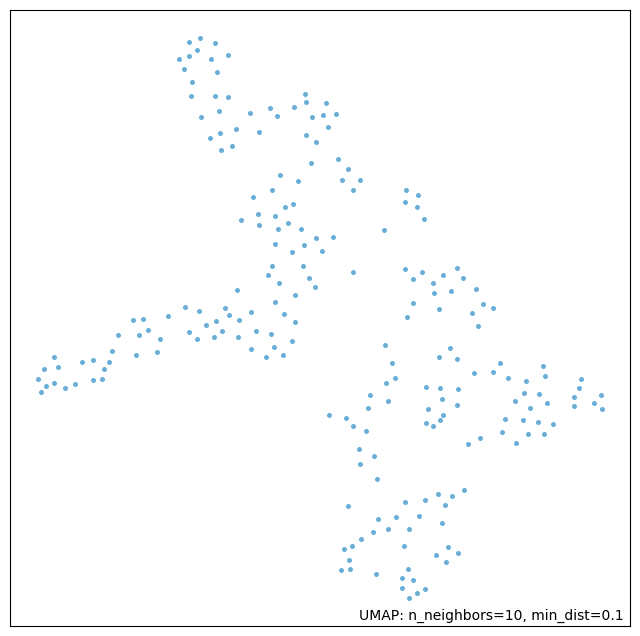

In [249]:
import umap
import umap.plot
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=2, 
                    negative_sample_rate=50, min_dist=0.1, metric=umap_metric, verbose=False, random_state=1)
emb = reducer.fit_transform(component_data)
umap.plot.points(reducer)

In [250]:
reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=20, 
                    min_dist=0, negative_sample_rate=50, 
                    metric=umap_metric, verbose=True, random_state=1)
embedding = reducer.fit_transform(component_data)

UMAP(min_dist=0, n_components=20, n_jobs=1, n_neighbors=10, negative_sample_rate=50, random_state=1, verbose=True)
Fri Aug 30 13:48:52 2024 Construct fuzzy simplicial set
Fri Aug 30 13:48:52 2024 Finding Nearest Neighbors
Fri Aug 30 13:48:52 2024 Finished Nearest Neighbor Search
Fri Aug 30 13:48:52 2024 Construct embedding


/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Aug 30 13:48:54 2024 Finished embedding


In [251]:
tr_data = embedding
# tr_data = component_data

In [265]:
final_linkage = 'complete'
final_metric = 'chebyshev'

In [266]:
clusterer = AgglomerativeClustering(linkage=final_linkage,
                                    metric=final_metric,
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(tr_data)
linkage_matrix = get_linkage_matrix(model)

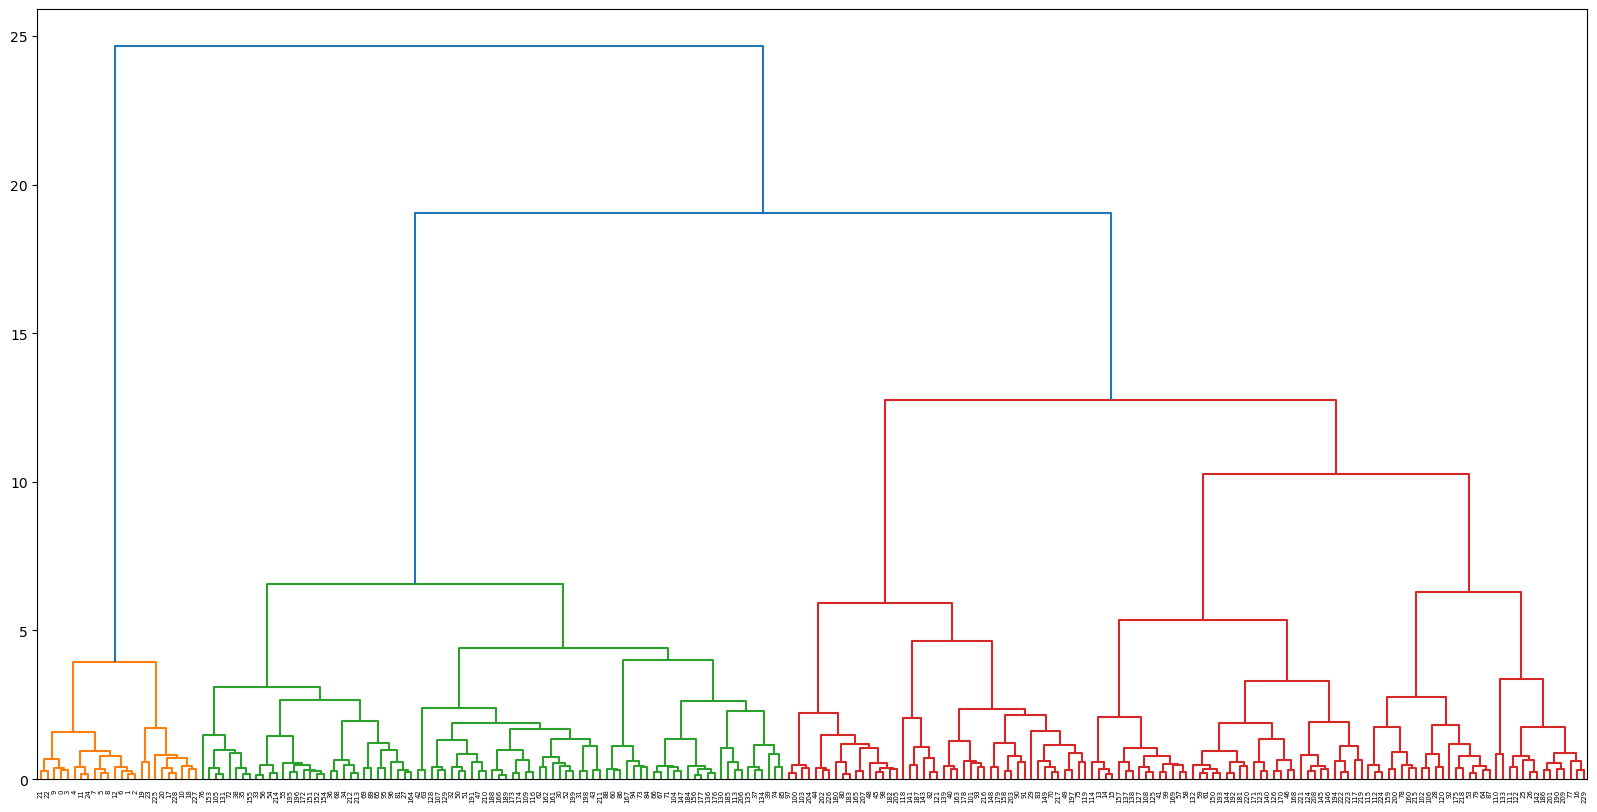

In [267]:
fig,ax = plt.subplots(figsize=(20,10))
_ = dendrogram(linkage_matrix, ax=ax)

In [275]:
cutoff = 3

In [276]:
clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
np.unique(clusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int32)

In [277]:
# gpd.read_parquet('../data/clusters_umap_freiburg_100_3_gaussian_euclidean_complete_chebyshev_5.pq').explore()

In [278]:


# from sklearn.cluster import KMeans, MiniBatchKMeans
# from sklearn.metrics import adjusted_rand_score
# clusters = KMeans(n_clusters=15, max_iter=5000, n_init=300, random_state=1).fit(tr_data).labels_
# np.unique(clusters)

In [279]:

# import hdbscan
# clusterer = hdbscan.HDBSCAN(min_cluster_size=n_neighbors)
# clusterer.fit(component_data)
# clusters = clusterer.labels_
# np.unique(clusters)

In [280]:
# morh_clusters = results[label]
morh_clusters = region_cluster_labels.values
clusters = pd.Series(clusters, index=component_data.index.values)
clusters = clusters.loc[morh_clusters].values

In [281]:
layer.get_fill_color = get_color(clusters)

In [282]:
# assert clusters.shape == results[label].shape

# for i in np.unique(results[label]):
#     idxs = np.where(results[label] == i)[0]
#     old_clusters = results[label][idxs]
#     new_clusters = clusters[idxs]
#     assert np.unique(old_clusters).shape[0] == 1
#     assert np.unique(new_clusters).shape[0] == 1
    

In [58]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(tessellation[tessellation.index >= 0], opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 605 ms, sys: 56.9 ms, total: 662 ms
Wall time: 661 ms


In [263]:
from sidecar import Sidecar
sc = Sidecar(title='Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

In [283]:
from core.cluster_validation import get_color
layer.get_fill_color = get_color(clusters)

In [284]:
# gpd.read_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq').explore()

In [285]:
fbc = gpd.read_parquet('../data/freiburg/freiburg_building_census.pq')

In [286]:
clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = clusters
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')
clrs_geometry = clrs_geometry.reset_index()

In [287]:
# Overlay cells with clusters to get intersections
overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')

# Calculate the area of overlap
overlap['area'] = overlap.geometry.area

# Find the cluster with the largest overlap for each cell
largest_overlap = overlap.loc[overlap.groupby(overlap['ID'])['area'].idxmax()]

/tmp/ipykernel_589934/715595176.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  overlap = gpd.overlay(fbc, clrs_geometry, how='intersection')


In [288]:
cols = largest_overlap.columns[largest_overlap.columns.str.contains('19') | largest_overlap.columns.str.contains('19')].sort_values()
age_cols = [cols[-1]] + list(cols[:-1])
age_cols

res = largest_overlap.iloc[:, 2:].dissolve('label', aggfunc='sum')
res[age_cols]

,Before 1919,1919 - 1948,1949 - 1978,1979 - 1986,1987 - 1990,1991 - 1995,1996 - 2000
label,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,535.0,118.0,359.0,69.0,6.0,19.0,18.0
4,1385.0,406.0,704.0,74.0,23.0,18.0,21.0
5,179.0,889.0,1000.0,174.0,34.0,21.0,43.0
6,200.0,151.0,402.0,13.0,10.0,18.0,135.0
7,81.0,319.0,1074.0,186.0,40.0,33.0,55.0
8,41.0,100.0,648.0,77.0,19.0,30.0,40.0
9,0.0,0.0,106.0,27.0,16.0,6.0,86.0


In [289]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[ind], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.347
  Kappa:    0.268



In [290]:
from sklearn import model_selection, ensemble, metrics
ind = largest_overlap.columns[2:-3]

X_train_rf, X_test, y_train, y_test = model_selection.train_test_split(largest_overlap[age_cols], largest_overlap["label"].astype(str), test_size=0.25, random_state=0)
model = ensemble.RandomForestClassifier(random_state=0, n_jobs=-1)
model.fit(X_train_rf, y_train)
pred = model.predict(X_test)

accuracy = metrics.accuracy_score(pred, y_test)
kappa = metrics.cohen_kappa_score(pred, y_test)

summary = f"""\
Evaluation metrics
==================
Basic model:
  Accuracy: {round(accuracy, 3)}
  Kappa:    {round(kappa, 3)}
"""

print(summary)

Evaluation metrics
Basic model:
  Accuracy: 0.231
  Kappa:    0.125



In [291]:
pd.Series(model.feature_importances_, index=model.feature_names_in_).sort_values(ascending=False).iloc[:10]


1949 - 1978    0.320713
Before 1919    0.245733
1919 - 1948    0.212132
1979 - 1986    0.104255
1996 - 2000    0.065185
1991 - 1995    0.027025
1987 - 1990    0.024956
dtype: float64

In [292]:
clrs_geometry.to_parquet(f'../data/clusters_umap_{region_id}_{min_cluster_size}_{spatial_lag}_{kernel}_{umap_metric}_{final_linkage}_{final_metric}_{cutoff}.pq')

In [293]:
component_data.to_parquet(f'../data/morphotopes_data_{region_id}_{min_cluster_size}_{spatial_lag}_{lag_type}_{kernel}.pq')

In [ ]:
# gkf = model_selection.StratifiedGroupKFold(n_splits=5)
# splits = gkf.split(
#     largest_overlap[ind],
#     largest_overlap["label"].astype(str),
#     groups=largest_overlap["label"],
# )

In [ ]:
# split_label = np.empty(len(largest_overlap), dtype=float)
# for i, (train, test) in enumerate(splits):
#     split_label[test] = i
# largest_overlap["split"] = split_label

In [ ]:
# ax = largest_overlap.plot(
#   "split", categorical=True, figsize=(9, 9), markersize=0.1, legend=True
# )
# largest_overlap.dissolve("label").convex_hull.boundary.plot(
#     ax=ax, color="k", linewidth=0.5, markersize=0
# )
# ax.set_axis_off()

In [ ]:
from libpysal import graph
import esda


In [ ]:
col = '1979 - 1986'

In [ ]:
contiguity = graph.Graph.build_contiguity(fbc, rook=False)
contiguity_r = contiguity.transform("r")
lisa = esda.Moran_Local(fbc[col].fillna(0), contiguity_r)

In [ ]:
# lisa.explore(
# fbc,
# crit_value=0.05,
#   prefer_canvas=True,
#   tiles="CartoDB Positron",
# )